# 决策树

决策树(Decision Tree)首先对数据进行处理，利用归纳算法生成可读的规则和决策树，然后使用决策对新数据进行分析，本质上是通过一系列规则对数据进行分类的过程

决策树是一种典型的分类方法。其中:
+ 每个内部结点表示一个属性上的判断
+ 每个分支代表一个判断结果的输出
+ 每个叶结点代表一种分类结果。

CLS算法是早期提出的决策树学习算法，是很多决策树学习算法的基础框架。
依据其中选择分类属性的策略不同，可以得到不同的决策树算法。比较常用的决策树有ID3，C4.5和CART三种和实现，其中CART一般优于其他决策树，并且可用于回归任务。

下面我们将编写代码实现这三种决策树算法。

### 任务一: 导入包和创建数据集
本实验所需要使用的函数库包括
+ log用于计算                                                                                                                                       
+ treePlotter为已经编写好的用于可视化决策树的代码，createPlot(tree)就可以调用
+ csv为对csv文件进行操作所需的包

本实验第一个使用的是天气情况数据集如图一所示，属性集合A={ 天气，温度，湿度，风速}， 类别标签有两个，类别集合L={进行（yes），取消(no)}。

<div align=center><img src ="img/dataset1.png" /></div>
<center>图一 天气情况数据集</center>

本实验中我们用字典嵌套的形式来表示一个决策树,如一个形如图二的决策树可表示为  {'weather': {0: {'wspeed': {0: 'yes', 2: 'no', 3: 'no'}}, 1: 'yes'}}

<div align=center><img src ="img/tree1.png" /></div>
<center>图二 决策树示例</center>

In [1064]:
from math import log
import treePlotter,csv 
import numpy as np
def createDataSet1():
    data=[
        [0, 0, 0, 0, 'yes'],
        [0, 1, 0, 1, 'yes'],
        [0, 2, 1, 0, 'no'],
        [0, 2, 1, 1, 'no'],
        [0, 1, 1, 0, 'no'],
        [1, 2, 1, 0, 'yes'],
        [1, 0, 0, 1, 'yes'],
        [1, 1, 1, 1, 'yes'],
        [1, 2, 0, 0, 'yes'],
        [2, 1, 1, 0, 'yes'],
        [2, 0, 0, 0, 'yes'],
        [2, 1, 0, 0, 'yes'],
        [2, 0, 0, 1, 'no'],
        [2, 1, 1, 1, 'no']
        ]
    features=['weather','temperature','humidity','wspeed']
    return data,features

data1,features1 = createDataSet1()
features1

['weather', 'temperature', 'humidity', 'wspeed']

### 任务二：ID3树

ID3 以信息熵的增益来作为分类的依据。假设样本集D中第$k$类样本占比$p_k$，可计算其对应信息熵为:$$Ent(D)=-\sum_k p_k log p_k$$ $Ent(D)$越小，代表数据集越有序，纯度越高。我们首先编写计算数据集香农熵的函数。
##### 2.1完成香农熵计算函数

In [1065]:
import math
def calcShannonEnt(dataSet):
    """
    函数：计算数据集香农熵
    参数：dataSet:数据集
        labels:数据标签
    返回：shannonEnt 数据集对应的香农熵
    """
    numEntries = len(dataSet) #样本数
    labelCounts = {} #统计不同label出现次数的字典（key为label,value为出现次数）
    shannonEnt = 0.0
    
    #计算labelCounts
    for featVec in dataSet:
        # 获取当前这条数据的label值
        currentLabel = featVec[-1]
        # 是新label，则在标签字典中新建对应的key，value的对应出现的次数，初始化为0
        # 已有则当前label出现次数+1
        labelCounts[currentLabel] = labelCounts.get(currentLabel,0) + 1
    
    ### START CODE HERE ###
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob*math.log(prob,2)    
    ### END CODE HERE ###   
    
    return shannonEnt

In [1066]:
print(calcShannonEnt(data1))
data1[0][-1] = 'maybe' #尝试增加一个分类选项，观察熵变化
print(calcShannonEnt(data1)) 
data1[0][-1] = 'yes' #还原

0.9402859586706309
1.2638091738835462


##### 2.2 完成基本功能函数
+ splitDataSet:用于在决策树每个分支，将特征取某个值的所有数据划分为一个数据集

In [1067]:
def splitDataSet(dataSet, axis, value):
    """
    函数：将axis列属性值为value的组合为一个数据集，并删除第axis列特征信息
    参数：axis:特征列索引
        value:待分离的特征取值
    返回：retDataSet:被分割出来的数据集
    """
    retDataSet = []
    for data in dataSet:
        # 如果数据集的第axis列值等于value，保留条数据，并删除第axis列特征信息
        if data[axis] == value:
            # 获取被降维特征前面的所有特征
            reducedFeatVec = data[:axis]
            # 接上被降维特征后面的所有特征
            reducedFeatVec.extend(data[axis + 1:])
            # 新的降维数据加入新的返回数据集中
            retDataSet.append(reducedFeatVec)
    return retDataSet

splitDataSet(data1,0,1) 

[[2, 1, 0, 'yes'], [0, 0, 1, 'yes'], [1, 1, 1, 'yes'], [2, 0, 0, 'yes']]

##### 2.3 用信息增益选择待分类的特征

那么假设用离散属性a有V个可能值，划分能产生V个分支，每个分支包含的数据记为$D^v$。
由此我们可以得出用属性a对样本集D划分的信息增益计算公式：
$$Gain(D,a)=Ent(D)-\sum_v\frac{|D^v|}{|D|}Ent(D^v)$$

In [1068]:
def chooseBestFeature_ID3(dataSet):
    """
    函数：利用香农熵，计算所有可能划分的信息增益，输出当前数据集最好的分类特征
    参数：dataSet
    返回：bestFeature:最优特征的index(下标)
    """
    numFeatures = len(dataSet[0]) - 1 #特征数
    baseEntropy = calcShannonEnt(dataSet) #Ent(D)
    bestInfoGain = 0.0 #信息增益
    bestFeature = -1 #最好信息增益特征
    
    #遍历每个特征
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList) #第i个特征的可能取值
        newEntropy = 0.0
        
        ### START CODE HERE ###
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        #计算以第i个特征划分产生的infoGain
        infoGain = baseEntropy - newEntropy

        #如果大于当前bestInfoGain，则保留当前划分为最优划分
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
        ### END CODE HERE ###   
    return bestFeature

chooseBestFeature_ID3(data1)

0

##### 2.4 生成ID3决策树

接下来我们可以用 **递归** 的方法生成决策树，其基本流程如下：
+ 划分条件：自根结点开始，通过选择出最佳属性进行划分树结构，并递归划分；
+ 停止条件：
    - 当前结点都是同一种类型；
    - 属性集为空，或所有样本在所有属性上取值相同，无法划分；
    - 数据集为空。

这是通用的创建决策树的函数，根据参数chooseBestFeature的不同，得到不同算法的决策树，当前任务中参数为刚刚编写的 chooseBestFeature_ID3。

#### 备注：
此处代码实现的ID3树，每个结点不能选取祖先结点用过的分类特征。
而实际上结点的不同子树，是有可能选取同样的分类特征的。
原因在于代码实现的  del (features[bestFeat]) 会导致一个特征被选用后，之后就再不能被选用。可以通过在递归时传入features的一份复制来避免这个问题。

In [1069]:
def majorityCnt(classList):
    """
    函数：计算占比最大的分类标签
    参数：classList分类标签
    返回：占比最大的分类标签
    """
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote]=0
        classCount[vote]+=1
    return max(classCount, key=classCount.get)

In [1070]:
def judge_same(dataset):
    """
    函数：判断数据集是否在所有属性上取值都相同
    参数：classList分类标签
    返回：占比最大的分类标签
    """
    for i in range(len(dataset)-1):
        if dataset[i][:-1] != dataset[i+1][:-1]:
            return False
    return True

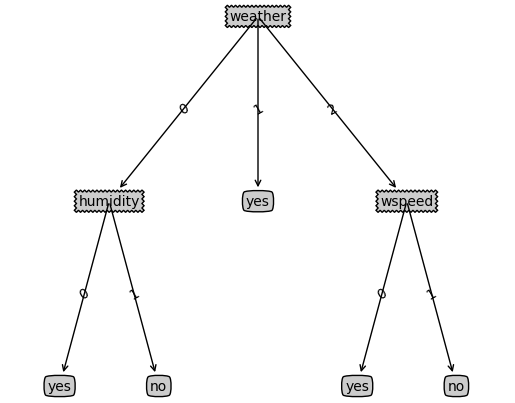

In [1071]:
def createTree(dataSet, features, chooseBestFeature):
    """
    函数：递归地根据数据集和数据特征名创建决策树
    参数：chooseBestFeature:函数作为参数，通过chooseBestFeature(dataSet)调用，
        根据参数的不同，获取由ID3或C4.5算法选择的最优特征的index
    返回：myTree:由集合表示的决策树
    """
    classList = [data[-1] for data in dataSet] #当前数据集的所有标签
    bestFeat = chooseBestFeature(dataSet) #当前数据集最优特征
    bestFeatName = features[bestFeat]   #最优特征的标签名
    myTree = {bestFeatName: {}} #构造当前结点——最优特征:子结点集合
    bestFeatValues = set([data[bestFeat] for data in dataSet]) #最优特征可能的取值，set去重

    del(features[bestFeat]) #删除已用过的分类标签

    ### START CODE HERE ###
    # 如果当前dataSet所有的标签相同，此结点分类完毕，结束决策，返回分类标签
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # 如果当前dataSet无特征，此结点分类完毕，结束决策，返回占比最大的分类标签
    if len(features) == 0:
        return majorityCnt(classList)
    # 如果当前dataSet在所有特征属性上取值都相同，结束决策，返回占比最大的分类标签
    if len(bestFeatValues) == 1:
        return majorityCnt(classList)
    # 由于bestFeatValues最佳特征可能取值来自于数据集中已有的取值，因此不需要考虑dataSet为空的情况


    # 否则，为每个最优特征取值，递归地创建子树
    for value in bestFeatValues:
        myTree[bestFeatName][value] = createTree(splitDataSet(dataSet, bestFeat, value), features[:], chooseBestFeature)
    ### END CODE HERE ###  

    return myTree

data1, labels1 = createDataSet1()
ID3Tree = createTree(data1, labels1,chooseBestFeature_ID3)
treePlotter.createPlot(ID3Tree)

### <center> Sample Output:</center>
<div align=center><img src ="img/tree0.png" /></div>

### 任务三：C4.5树

ID3用信息增益选择属性的方式会让他对取值数目较多的属性产生偏好，接下来我们通过一个直观的例子来说明。

假设数据集变成如下所示，某个属性(如风速)变为每个样本一个值的情况，构建一个ID3树。

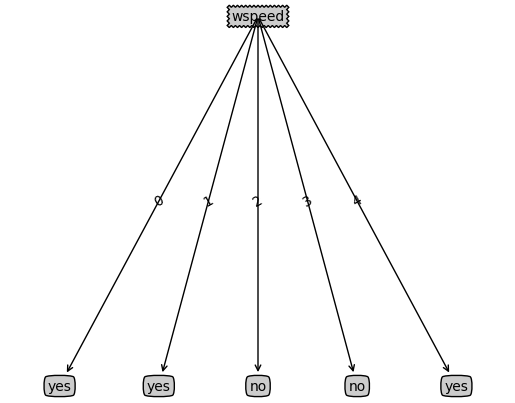

In [1072]:
def createDataSet2():
    data=[
            [0, 0, 1, 0, 'yes'],
            [1, 1, 0, 1, 'yes'],
            [0, 0, 0, 2, 'no'],
            [0, 1, 1, 3, 'no'],
            [1, 1, 1, 4, 'yes']
            ]
    features2=['weather','temperature','humidity','wspeed']
    return data,features2
data2, features2 = createDataSet2()
ID3Tree = createTree(data2, features2, chooseBestFeature_ID3)
treePlotter.createPlot(ID3Tree)

### <center> Sample Output:</center>
<div align=center><img src ="img/tree4.png" /></div>

可以观察到，ID3树利用了wspeed属性为每一个样本创建了分支，这样得到的决策树显然泛化性会很差。
为了进行改进，我们可以设想为信息增益增加一个类似于正则项的惩罚参数，在特征取值多时，降低信息增益，以寻取特征取值数量和信息增益之间的权衡。

**信息增益比 = 惩罚参数 * 信息增益**

C4.5算法为属性定义一个Intrinsic Value(IV)来构建这个惩罚参数：$$IV(a)=-\sum_{v=1}^{V}\frac{|D^v|}{|D|}log\frac{|D^v|}{|D|}$$
其数学意义为：以特征a作为随机变量的熵的倒数。

假设某个属性将样本等分为x份，可得其$IV=-log(1/x)$，如图三所示，观察可以发现，样本划分越多，x越大，其值越大

<div align=center><img src ="img/plot1.png" /></div>
<center> 图三 特殊情况IV曲线示意图</center>

于是可将信息增益改进为信息增益比$$GainRatio(D,a)=\frac{Gain(D,a)}{IV(a)}$$

此外，不难发现，IV公式和香农熵/信息熵是一致的，属性可取的属性值越多，系统越混乱，纯度越低，熵越大。

#### 任务3.1 用信息增益比选择分类特征

In [1073]:
import numpy as np
def chooseBestFeature_C45(dataSet):
    """
    函数：计算所有可能划分的信息增益比，输出当前数据集最好的分类特征
    参数：dataSet
    返回：bestFeature:最优特征的index(下标)
    """
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList) 
        newEntropy = 0.0
        IV = 0.0 
        
        ### START CODE HERE ### 
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
            IV += -prob * np.log2(prob)
        # 计算以第i个特征划分的infoGain，以及其IV
        infoGain = baseEntropy - newEntropy
        # 注意IV=0时直接continue，可以思考一下什么情况会使IV=0
        if IV == 0:
            continue
        # 计算GainRatio衰减
        gainRatio = infoGain / IV
        # 如果大于当前最优，则保留当前划分为最优划分
        if gainRatio > bestInfoGain:
            bestInfoGain = gainRatio
            bestFeature = i
        ### END CODE HERE ###
    
    return bestFeature

#### 任务3.2 生成C4.5树

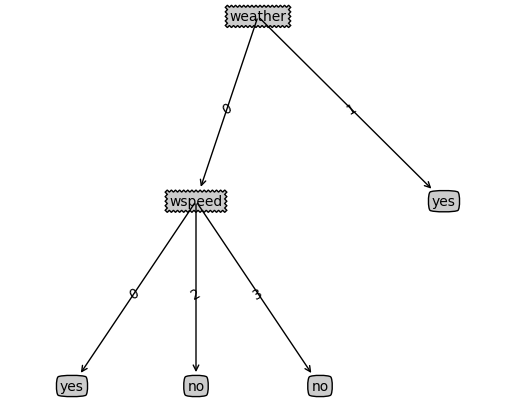

In [1074]:
data2, labels2 = createDataSet2()
C45Tree = createTree(data2, labels2, chooseBestFeature_C45)
treePlotter.createPlot(C45Tree)

### <center> Sample Output:</center>
<div align=center><img src ="img/tree5.png" /></div>

可以观察到，C4.5算法的确对特征取值较少的属性产生了更多偏好，可以有效的避免上述ID3树存在的问题。但C4.5算法分类结果还是存在一定的过拟合。

### 任务四：剪枝

在决策树学习的过程中，为了尽量正确分类训练样本，节点划分过程将不断重复，有时会造成决策树分支过多，这时就可能因为训练样本学得太好导致“过拟合”，剪枝是决策树学习算法应对“过拟合”的主要手段。

决策树剪枝的基本策略有“预剪枝”和“后剪枝”。预剪枝是指在决策树生成的过程中，对每个结点在划分前进行估计，若当前结点的划分不能带来决策树泛化性能的提升，则停止划分并将当前结点标记为叶结点；后剪枝是指从训练集生成一棵完整的决策树，然后自底向上地对非叶结点进行考察，若将该结点对应的子树替换成叶结点能带来泛化性能的提升，则将该结点替换为叶子结点。

这里我们将实现对ID3决策树进行“预剪枝”

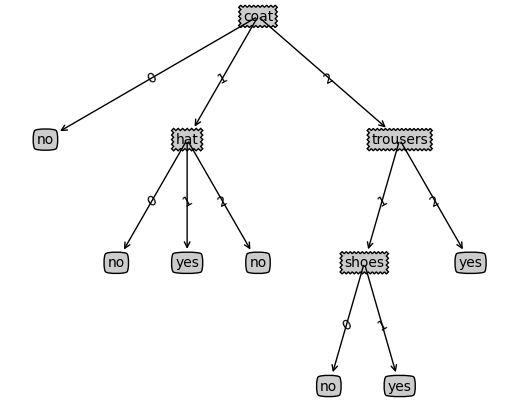

In [1075]:
def createDataSet3():
    data=[
            [1, 2, 1, 0, 2, 0, 'yes'],
            [2, 2, 2, 0, 2, 0, 'yes'],
            [2, 2, 1, 0, 2, 0, 'yes'],
            [1, 1, 1, 0, 1, 1, 'yes'],
            [2, 1, 1, 1, 1, 1, 'yes'],
            [1, 0, 0, 0, 0, 1, 'no'],
            [0, 1, 2, 1, 2, 0, 'no'],
            [2, 1, 1, 0, 1, 1, 'no'],
            [0, 2, 1, 2, 0, 0, 'no'],
            [1, 2, 2, 1, 1, 0, 'no']
            ]
    testdata=[
            [1, 2, 2, 0, 2, 0, 'yes'],
            [0, 2, 1, 0, 2, 0, 'yes'],
            [2, 1, 1, 0, 1, 0, 'yes'],
            [2, 0, 2, 1, 1, 0, 'no'],
            [0, 0, 0, 2, 0, 0, 'no'],
            [0, 2, 1, 2, 0, 1, 'no'],
            [1, 1, 1, 1, 2, 0, 'no']
            ]
    features3=['coat','trousers','hat','shoes','shirt','scarf']
    return data,testdata,features3
data3, testdata, features3 = createDataSet3()
ID3Tree = createTree(data3, features3, chooseBestFeature_ID3)
treePlotter.createPlot(ID3Tree)

### <center> Sample Output:</center>
<div align=center><img src ="img/tree6.png" /></div>
<center> 未剪枝决策树示例</center>

In [1076]:
def testingMajor(major, data_test):
    """
    函数：计算不保留子树造成的错误数量
    参数：data_test，major：占比最大的分类标签
    返回：错误数量
    """
    error = 0.0
    for i in range(len(data_test)):
        if major != data_test[i][-1]:
            error += 1

    return float(error)

In [1077]:
def testing_feat(bestFeatIndex, train_data, test_data):
    """
    函数：计算保留子树造成的错误数量
    参数：bestFeatIndex:最优特征的index(下标)，train_data：训练数据集, test_data：测试数据集
    返回：错误数量
    """
    class_list = [example[-1] for example in train_data]
    train_data = [example[bestFeatIndex] for example in train_data]
    test_data = [(example[bestFeatIndex], example[-1]) for example in test_data]
    all_feat = set(train_data)
    error = 0.0
    for value in all_feat:
        class_feat = [class_list[i] for i in range(len(class_list)) if train_data[i] == value]
        major = majorityCnt(class_feat)
        for data in test_data:
            if data[0] == value and data[1] != major:
                error += 1.0
    return error

In [1078]:
def createTree_prune(dataSet,labels,test_data,chooseBestFeature,mode='prev'):
    """
    函数：递归地根据数据集和数据特征名创建预剪枝决策树
    参数：dataSet：训练数据集，labels：数据标签，test_data：测试数据集，chooseBestFeature:函数作为参数，通过chooseBestFeature(dataSet)调用，
        根据参数的不同，获取由ID3或C4.5算法选择的最优特征的index
    返回：myTree:由集合表示的决策树
    """
    classList=[example[-1] for example in dataSet]
    # dataSet指的是当前的数据集,不是最初的数据集
    # classList指的是当前数据集的所有标签(不去重)

    #下面是递归截止条件
    if classList.count(classList[0])==len(classList):#这个意思是如果当前数据集中的所有数据都属于同一个类别
        return classList[0]
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    if judge_same(dataSet):# 数据集在所有属性上取值都相同
        return majorityCnt(classList)

    #选择最佳分割特征
    labels_copy = labels
    #labels_copy = copy.deepcopy(labels)#深拷贝就是:labels_copy和lables撇清关系
    bestFeat=chooseBestFeature(dataSet)
    bestFeatLabel=labels[bestFeat]
    if mode == "prev":
        ### START CODE HERE ###        
        #如果剪枝前的错误数量小于剪枝后的错误数量,那么就保留该子树
        if testingMajor(majorityCnt(classList), dataSet) <= testing_feat(bestFeat, dataSet, test_data):
            return majorityCnt(classList)
        ### END CODE HERE ###

    myTree = {bestFeatLabel: {}}
    featValues=[example[bestFeat] for example in dataSet]
    uniqueVals=set(featValues)
    #uniqueVals用来获得当前数据集的最佳分割属性剩余的取值有哪些

    del (labels[bestFeat])#删除根节点的已经用过的特征

    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree_prune(splitDataSet(dataSet, bestFeat, value), subLabels,splitDataSet(test_data, bestFeat, value),chooseBestFeature, mode=mode)

    return myTree

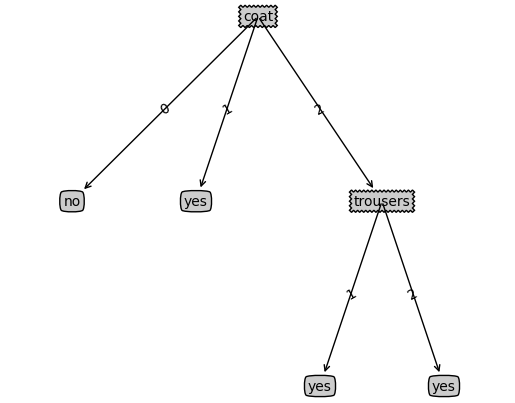

In [1079]:
data3, testdata, features3 = createDataSet3()
MyTree = createTree_prune(data3, features3, testdata, chooseBestFeature_ID3)
treePlotter.createPlot(MyTree)

### <center> Sample Output:</center>
<div align=center><img src ="img/tree7.png" /></div>

### 任务五：CART

前面的实验我们发现ID3和C4.5算法在用于分类问题是有效的，那么决策树可以适用于回归问题吗？

CART(Classification and regression tree)如其名，便是可以既可以用于解决分类问题，又可以用于解决回归问题的决策树算法。

- 在解决分类问题时：

ID3/C4.5基于信息论熵模型选择一个离散的特征进行分类，根据特征取值数目一次性划分若干子结点，然后子结点的数据集将不再包含这个特征，这个特征不再参与接下来的分类，这意味着这种决策树模型是不能直接处理连续取值的特征的，除非划分区间将其离散化。

CART则根据**基尼系数(Gini Index)** 为连续或离散的特征选择一个划分点，产生左右两个分支，生成二叉树。在产生分支后，仍可以再利用这个特征，参与接下来的分类，产生下一个分支。用叶子结点样本**最多的标签**作为预测输出。

- 在解决回归问题时：

CART根据**平方损失**选择最优划分特征和划分点，并用叶子结点样本**标签均值**作为预测输出。

接下来我们来具体实现CART回归树，并尝试用于解决一个分类问题。

##### 任务5.1 iris数据集读取和预处理

Iris数据集即鸢尾属植物数据集，该数据集测量了所有150个样本的4个特征，分别是：
+ sepal length（花萼长度）
+ sepal width（花萼宽度）
+ petal length（花瓣长度）
+ petal width（花瓣宽度）

标签为其种属：Iris Setosa，Iris Versicolour，Iris Virginica。该数据集被广泛用于分类算法示例，我们可以看到其4个特征取值均是连续的。数据集存储在 iris.csv 文件中,我们从中手动划分一部分作为训练集。


In [1080]:
def createDataSetIris():
    '''
    函数：获取鸢尾花数据集，以及预处理
    返回：
        Data:构建决策树的数据集(因打乱有一定随机性)
        Data_test:手动划分的测试集
        featrues：特征名列表
        labels：标签名列表
    '''
    labels = ["setosa","versicolor","virginica"]
    with open('iris.csv','r') as f:
        rawData = np.array(list(csv.reader(f)))
        features = np.array(rawData[0,1:-1]) 
        dataSet = np.array(rawData[1:,1:]) #去除序号和特征列
        np.random.seed(2023)
        np.random.shuffle(dataSet) #打乱（之前如果不加array()得到的会是引用，rawData会被一并打乱）
    return rawData[1:,1:], dataSet, features, labels

rawData, data, features, labels = createDataSetIris()
print(rawData[0]) 
print(data[0])
print(features) 
print(labels) 

['5.1' '3.5' '1.4' '0.2' 'setosa']
['6.4' '2.8' '5.6' '2.1' 'virginica']
['Sepal.Length' 'Sepal.Width' 'Petal.Length' 'Petal.Width']
['setosa', 'versicolor', 'virginica']


##### 5.2 完成基尼指数计算函数

数据集D的基尼值(Gini Index)计算公式如下：
$$Gini(D)=\sum_{k=1}^{K}\sum_{k'≠K}p_kp_k'=1-\sum_{k=1}^{K}p_k^2$$
其数学意义为，从数据集中任选两个样本，类别不一致的概率。其值越小，数据集纯度越高。

数据集D某个划分a的基尼系数计算如下：
$$GiniIndex(D,a)=\sum_{v=1}^{V}\frac{|D^v|}{|D|}Gini(D^v)$$

In [1081]:
def calcGini(dataSet):
    '''
    函数：计算数据集基尼值
    参数：dataSet:数据集
    返回: Gini值
    ''' 
    counts = [] #每个标签在数据集中出现的次数
    count = len(dataSet) #数据集长度
    if count == 0:
        return 0
    for label in labels:
        counts.append([d[-1] == label for d in dataSet].count(True))
    ### START CODE HERE ###    
    gini = 1
    for c in counts:
        prob = c / count
        gini -= prob * prob
    ### END CODE HERE ###
    
    return gini

calcGini(rawData) 

0.6666666666666665

##### 5.3 完成基本功能函数
+ binarySplitDataSet: 和ID3,C4.5不同，CART每个划分均为二分，且不删除特征信息。这里由于已知数据集特征取值全是连续取值型的, 对算法的部分功能进行了并不严谨的简化。实际应用中的CART还应该判断特征取值是否离散，若离散，并把feature等于和不等于value的数据划分为两个数据集。
+ classificationLeaf:用于分类命题，此处实现的是多数表决器，叶结点输出数据集最多的标签作为分类。如果是用于回归问题，叶结点应该输出的是数据集列的均值作为回归预测。

In [1082]:
def binarySplitDataSet(dataSet, feature, value):
    '''
    函数：将数据集按特征列的某一取值换分为左右两个子数据集
    参数：dataSet:数据集
        feature:数据集中某一特征列
        value:该特征列中的某个取值
    返回：左右子数据集
    '''
    matLeft = np.array([d for d in dataSet if d[feature] <= value])
    matRight = np.array([d for d in dataSet if d[feature] > value])
    return matLeft,matRight

binarySplitDataSet(rawData,0,"4.7")[0]

array([['4.7', '3.2', '1.3', '0.2', 'setosa'],
       ['4.6', '3.1', '1.5', '0.2', 'setosa'],
       ['4.6', '3.4', '1.4', '0.3', 'setosa'],
       ['4.4', '2.9', '1.4', '0.2', 'setosa'],
       ['4.3', '3', '1.1', '0.1', 'setosa'],
       ['4.6', '3.6', '1', '0.2', 'setosa'],
       ['4.7', '3.2', '1.6', '0.2', 'setosa'],
       ['4.4', '3', '1.3', '0.2', 'setosa'],
       ['4.5', '2.3', '1.3', '0.3', 'setosa'],
       ['4.4', '3.2', '1.3', '0.2', 'setosa'],
       ['4.6', '3.2', '1.4', '0.2', 'setosa']], dtype='<U12')

In [1083]:
def classifyLeaf(dataSet, labels):
    '''
    函数：求数据集最多的标签，用于结点分类
    参数：dataSet:数据集
        labels:标签名列表
    返回：该标签的index
    '''
    counts = [] 
    for label in labels:
        counts.append([d[-1] == label for d in dataSet].count(True))
    return labels[np.argmax(counts)] #argmax：使counts取最大值的下标

classifyLeaf(rawData[40:120],labels) 

'versicolor'

##### 5.4 用基尼系数选择特征及划分点

CART在这一步选择的不仅是特征，而是特征以及该特征的一个分界点。CART要遍历所有特征的所有样本取值作为分界点的Gini系数，从中找出最优特征和最优划分。

在这里我们进一步地为决策树设定停止条件——阈值。当结点样本数足够小或者Gini增益足够小的时候停止划分，将结点中最多的样本作为结点的决策分类。

In [1084]:
def chooseBestSplit(dataSet, labels, leafType=classifyLeaf, errType=calcGini, threshold=(0.01,7)):
    '''
    函数：利用基尼系数选择最佳划分特征及相应的划分点
    参数：dataSet:数据集
        leafType:叶结点输出函数(当前实验为分类)
        errType:损失函数，选择划分的依据(分类问题用的就是GiniIndex)
        threshold: Gini阈值，样本阈值(结点Gini或样本数低于阈值时停止)
    返回：bestFeatureIndex:划分特征
        bestFeatureValue:最优特征划分点
    '''
    thresholdErr = threshold[0] #Gini阈值
    thresholdSamples = threshold[1] #样本阈值
    err = errType(dataSet)
    bestErr = np.inf
    bestFeatureIndex = 0 #最优特征的index
    bestFeatureValue = 0 #最优特征划分点

    ### START CODE HERE ###    
    #当数据中输出值都相等时，返回叶结点（即feature=None,value=结点分类）
    if err == 0:
        return None,leafType(dataSet, labels) 
    #尝试所有特征的所有取值，二分数据集，计算err(本实验为Gini)，保留bestErr
    leftDataSet = None
    rightDataSet = None
    for feature in range(len(features)):
        for value in set(dataSet[:,feature]):
            left,right = binarySplitDataSet(dataSet,feature,value)
            err = errType(left)*len(left)/len(dataSet) + errType(right)*len(right)/len(dataSet)
            #err = errType(left) + errType(right)
            #print(features[feature], value, err)
            if err < bestErr:
                bestErr = err
                bestFeatureIndex = feature
                bestFeatureValue = value
                leftDataSet = left
                rightDataSet = right
    #检验Gini阈值，若是则不再划分，返回叶结点
    if bestErr < thresholdErr:
        return None,leafType(dataSet, labels)    
    #检验左右数据集的样本数是否小于阈值，若是则不再划分，返回叶结点
    if len(leftDataSet) < thresholdSamples or len(rightDataSet) < thresholdSamples:
        return None,leafType(dataSet, labels)   
    ### END CODE HERE ###  
    #print("-"*20)
    return bestFeatureIndex,bestFeatureValue

chooseBestSplit(rawData, labels)

(2, '1.9')

##### 5.5 生成CART

根据参数leafType，errType的不同，生成CART分类树或是CART回归树。

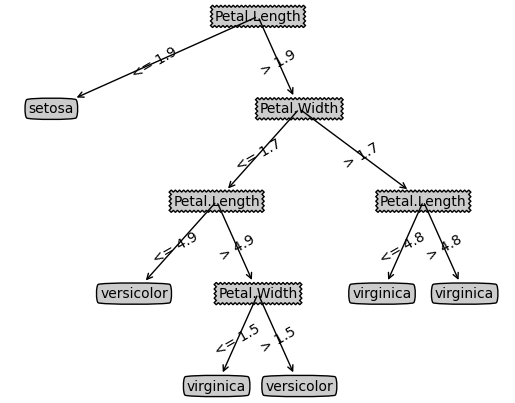

In [1085]:
def createTree_CART(dataSet, labels, leafType=classifyLeaf, errType=calcGini, threshold=(0.01,7)):

    '''
    函数：建立CART树
    参数：dataSet:数据集
        leafType:叶结点输出函数(当前实验为分类)
        errType:损失函数，选择划分的依据(分类问题用的就是GiniIndex)
        threshold: Gini阈值，样本阈值(结点Gini或样本数低于阈值时停止)
    返回：CART树
    '''
    feature,value = chooseBestSplit(dataSet, labels, leafType, errType, threshold)

    ### START CODE HERE ###    

    #是叶结点则返回决策分类（chooseBestSplit返回None时表明这里是叶结点）
    #否则创建分支，递归生成子树
    if feature == None:
        return value
    else:
        nodeFeature = features[feature]
        #print(nodeFeature, value)
        myTree = {nodeFeature:{}}
        #对于每个可能的分类，递归生成子树
        leftDataSet,rightDataSet = binarySplitDataSet(dataSet, feature, value)
        myTree[nodeFeature][f'<= {value}'] = createTree_CART(leftDataSet, labels, leafType, errType, threshold)
        myTree[nodeFeature][f'> {value}'] = createTree_CART(rightDataSet, labels, leafType, errType, threshold)           
    
    ### END CODE HERE ###    
    
    return myTree

CARTTree = createTree_CART(data, labels, classifyLeaf, calcGini, (0.01,3))
treePlotter.createPlot(CARTTree)

### <center> Sample Output:</center>
<div align=center><img src ="img/tree8.png" /></div>

#### 备注：
+ 由于实现细节，实现顺序有所不同，最终生成的树可能也不一样，之前函数的测试样例通过即可。
+ 一个分支两个子结点分类相同是未达到Gini阈值，却达到样本阈值导致的，可以通过更改特征选择代码中，停止划分判断的顺序避免。
+ 从实例可以看到一些CART树的特点，如：连续属性二分划分特征，特征可重复用于结点分类等等